# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

We've seen the power of transfer learning and fine-tuning,now it's time to scale up to all of the classes in Food101.

Our goal is to beat the original Food101 paper with 10% of the training data. (50.76%)

In [ ]:
!nvidia-smi

Thu Apr 18 16:04:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-04-18 17:11:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-18 17:11:33 (112 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2024-04-18 17:11:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  21.9MB/s    in 72s     

2024-04-18 17:12:48 (21.5 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [ ]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [ ]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beet_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baklava'.
There are 0 directories and 75 images in '10

In [ ]:
# Create train data 10 per cent
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

train_data_all_10_per_cent = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE
)

test_data = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    shuffle=False
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model transfer learning on 10% of food101

In [ ]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomZoom(0.2),
    keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomHeight(0.2),
    keras.layers.experimental.preprocessing.RandomWidth(0.2)
])

In [ ]:
# Setup the base model and freeze its layers
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = Input(IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(101, "softmax")(x)

model = keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (50

In [ ]:
# Compile
model.compile(
    optimizer=Adam(),
    loss=categorical_crossentropy,
    metrics=["accuracy"]
)

In [ ]:
# Fit the model
history_all_classes_10_per_cent = model.fit(
    train_data_all_10_per_cent,
    epochs=5,
    steps_per_epoch=len(train_data_all_10_per_cent),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data
    callbacks=[model_checkpoint_callback]
)

Epoch 1/5
237/237 [==============================] - 183s 723ms/step - loss: 3.3882 - accuracy: 0.2656 - val_loss: 2.5267 - val_accuracy: 0.4221
Epoch 2/5
237/237 [==============================] - 120s 502ms/step - loss: 2.1958 - accuracy: 0.4904 - val_loss: 2.0791 - val_accuracy: 0.4910
Epoch 3/5
237/237 [==============================] - 95s 397ms/step - loss: 1.8178 - accuracy: 0.5674 - val_loss: 1.8858 - val_accuracy: 0.5246
Epoch 4/5
237/237 [==============================] - 96s 403ms/step - loss: 1.6028 - accuracy: 0.6114 - val_loss: 1.8328 - val_accuracy: 0.5270
Epoch 5/5
237/237 [==============================] - 99s 411ms/step - loss: 1.4551 - accuracy: 0.6432 - val_loss: 1.7818 - val_accuracy: 0.5315


In [ ]:
all_classes_10_percent_feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 70s 89ms/step - loss: 1.5844 - accuracy: 0.5807


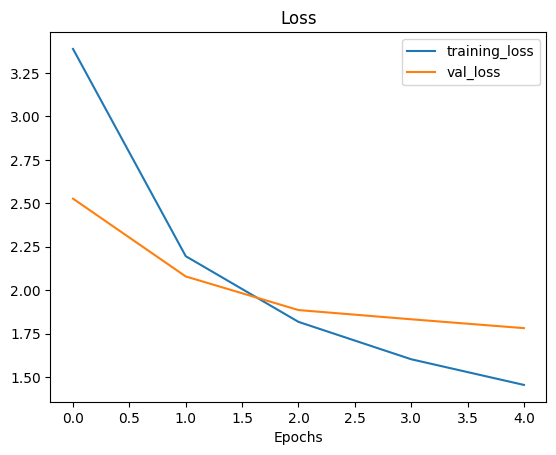

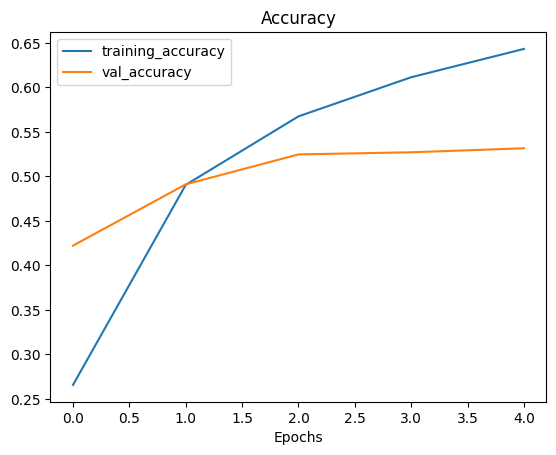

In [ ]:
plot_loss_curves(history_all_classes_10_per_cent)

## Fine-tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=categorical_crossentropy,
    metrics=["accuracy"]
)

In [ ]:
history_all_classes_10_percent_fine_tune = model.fit(
    train_data_all_10_per_cent,
    epochs=10,
    steps_per_epoch=len(train_data_all_10_per_cent),
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    initial_epoch=history_all_classes_10_per_cent.epoch[-1]
)

Epoch 5/10
237/237 [==============================] - 114s 434ms/step - loss: 1.2063 - accuracy: 0.6824 - val_loss: 1.7440 - val_accuracy: 0.5432
Epoch 6/10
237/237 [==============================] - 98s 410ms/step - loss: 1.1022 - accuracy: 0.7069 - val_loss: 1.7500 - val_accuracy: 0.5456
Epoch 7/10
237/237 [==============================] - 77s 324ms/step - loss: 1.0197 - accuracy: 0.7267 - val_loss: 1.7297 - val_accuracy: 0.5527
Epoch 8/10
237/237 [==============================] - 80s 333ms/step - loss: 0.9436 - accuracy: 0.7518 - val_loss: 1.7269 - val_accuracy: 0.5503
Epoch 9/10
237/237 [==============================] - 81s 337ms/step - loss: 0.8774 - accuracy: 0.7628 - val_loss: 1.7263 - val_accuracy: 0.5519
Epoch 10/10
237/237 [==============================] - 78s 324ms/step - loss: 0.8335 - accuracy: 0.7790 - val_loss: 1.7302 - val_accuracy: 0.5501


In [ ]:
all_classes_10_percent_fine_tuning_results = model.evaluate(test_data)

790/790 [==============================] - 84s 106ms/step - loss: 1.4965 - accuracy: 0.6021


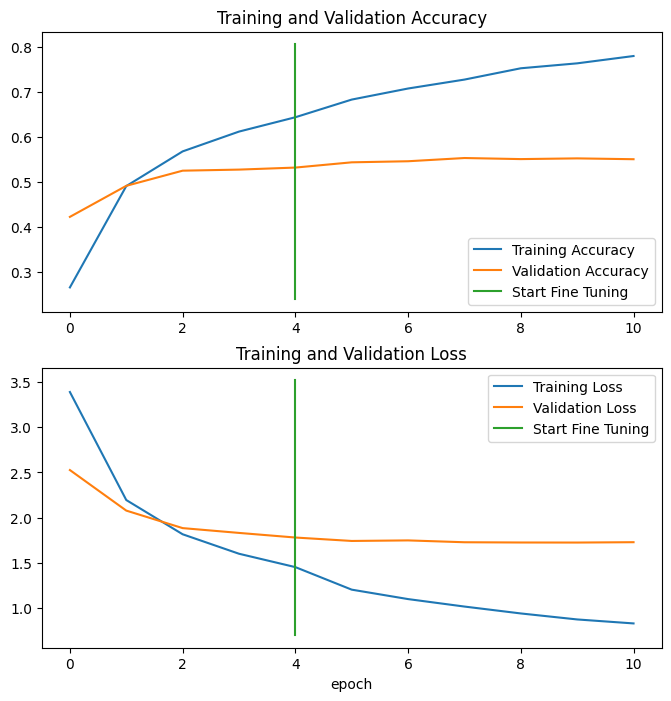

In [ ]:
compare_historys(history_all_classes_10_per_cent, history_all_classes_10_percent_fine_tune)

In [ ]:
all_classes_10_percent_feature_extraction_results, all_classes_10_percent_fine_tuning_results

([1.5844284296035767, 0.5807128548622131],
 [1.4965053796768188, 0.6020990014076233])

## Save and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [ ]:
# Save our fine-tuned model
model.save("model.keras")

In [ ]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("model.keras")

In [ ]:
# Evaluate loaded model and compare perfomance
loaded_model_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 66s 76ms/step - loss: 1.5401 - accuracy: 0.6013


In [ ]:
import numpy as np
np.isclose(all_classes_10_percent_fine_tuning_results, loaded_model_results)

array([ True,  True])

## Evaluating the perfomance of the big dog model across all different classes

Let's make some predictions,  visualize them and then later find out which predictions were the "most" wrong.

In [ ]:
import tensorflow as tf

! wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-04-18 17:13:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.2’

06_101_food_class_1 100%[===================>]  44.59M  14.5MB/s    in 3.1s    

2024-04-18 17:13:13 (14.5 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.2’ saved [46760742/46760742]



In [ ]:
from helper_functions import *

In [ ]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Loading saved model
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model
results_downloaded_model = model.evaluate(test_data)

790/790 [==============================] - 67s 78ms/step - loss: 1.8027 - accuracy: 0.6078


In [ ]:
model.summary()

Model: "functional_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_9  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 41

In [ ]:
## Making predictions on our trained model
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 60s 75ms/step


In [ ]:
len(preds_probs)

25250

In [ ]:
# What's the shape of our predictios
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [ ]:
preds_probs[0]

array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
       8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
       1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
       2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
       6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
       1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
       8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
       2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
       1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
       1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
       8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
       2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
       3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
       8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.74041920e-05,
      

In [ ]:
len(preds_probs[0])

101

In [ ]:
tf.reduce_sum(preds_probs[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.99999994>

In [ ]:
tf.argmax(preds_probs[0])

<tf.Tensor: shape=(), dtype=int64, numpy=52>

In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
# Get the pred_classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How to they look like
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
len(pred_classes)

25250

In [ ]:
# To get our test labels, we need to unravel our test_data BatchDataset
y_labels = []


for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [ ]:
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [ ]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [ ]:
import sklearn

In [ ]:
sklearn_accuracy = sklearn.metrics.accuracy_score(y_labels, pred_classes)

In [ ]:
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

In [ ]:
sklearn_accuracy

0.6077623762376237

## Let's get visual: making a confusion matrix

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_labels, pred_classes, classes=test_data.class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

Output hidden; open in https://colab.research.google.com to view.

## Let's keep tge evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class called classification report, let's try it out.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
# Get a dict of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

In [ ]:
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

Let's plot all of our classes F1-scores

In [ ]:
# Create empty dict
class_f1_scores = {}
# Loop through classification report dict items
for key, value in classification_report_dict.items():
  if key == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dict
    class_f1_scores[test_data.class_names[int(key)]] = value["f1-score"]

In [ ]:
# Turn f1-scores into dataframe
import pandas as pd

f1_scores = pd.DataFrame({
  "class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

f1_scores

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


In [ ]:

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')

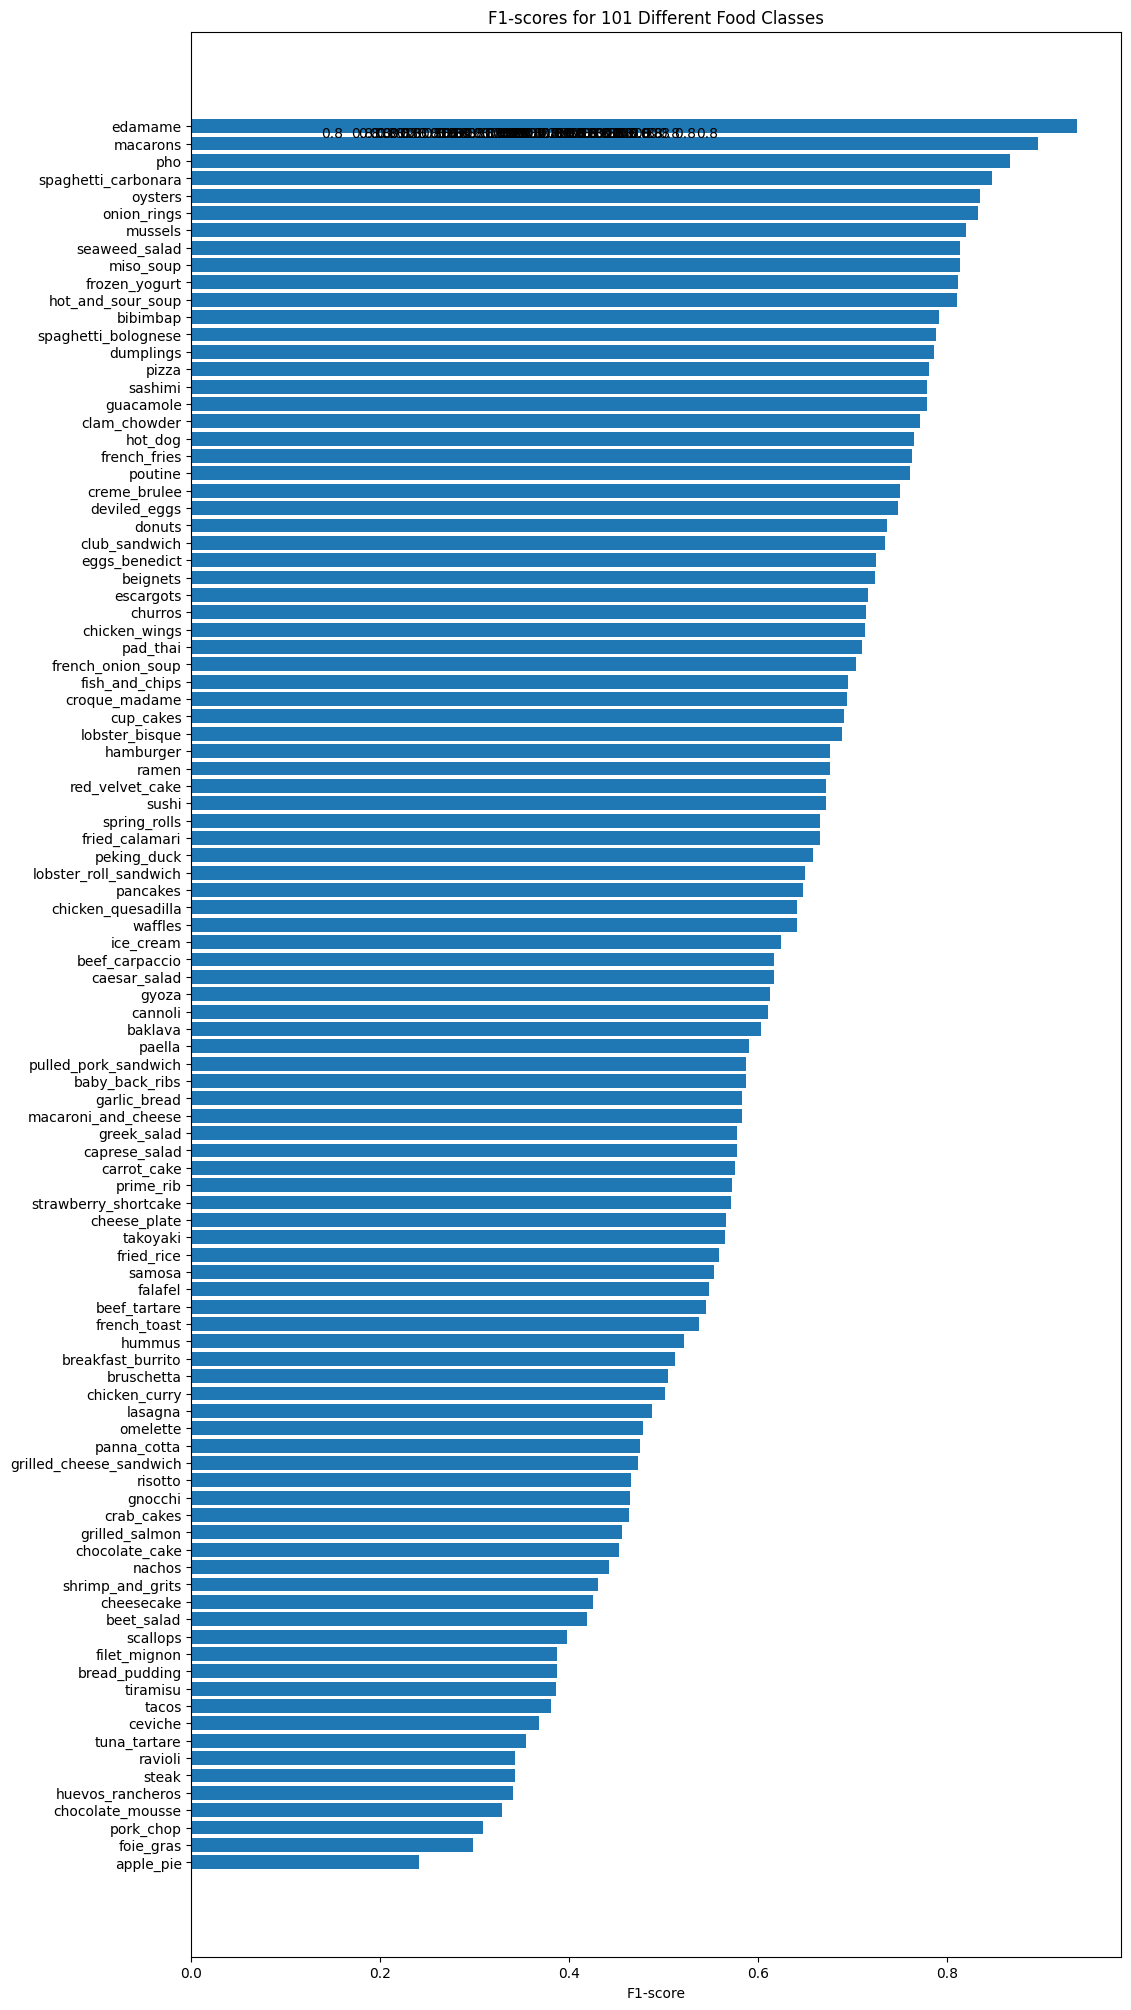

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes")
ax.invert_yaxis() # reverse the order
autolabel(scores, xpos="right");

## Visualizing predictions on test images

We need to:
* Read in  target image filepath using tf.io.read_file()
* Turn img into a tensor tf.io.decode_image()
* Resize the imge tensor to be the same size as input
* Normalize (if necessary)

In [ ]:
# load and prepare images
def load_and_prep(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns into tensor and reshapes
  """
  # Read in the img
  img = tf.io.read_file(filename)

  # Decode img into a tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the img
  img = tf.image.resize(img, size=[img_shape, img_shape])

  # Scale
  if scale:
    return img/255.
  return img

Visualize images for the target label and our model's predictions.

1. Load random imgs from test_data
2. Make predictions on the loaded imgs
3. Plot the orig. imgs & pred. imgs, pred prob. and truth label

1/1 [==============================] - 0s 26ms/step


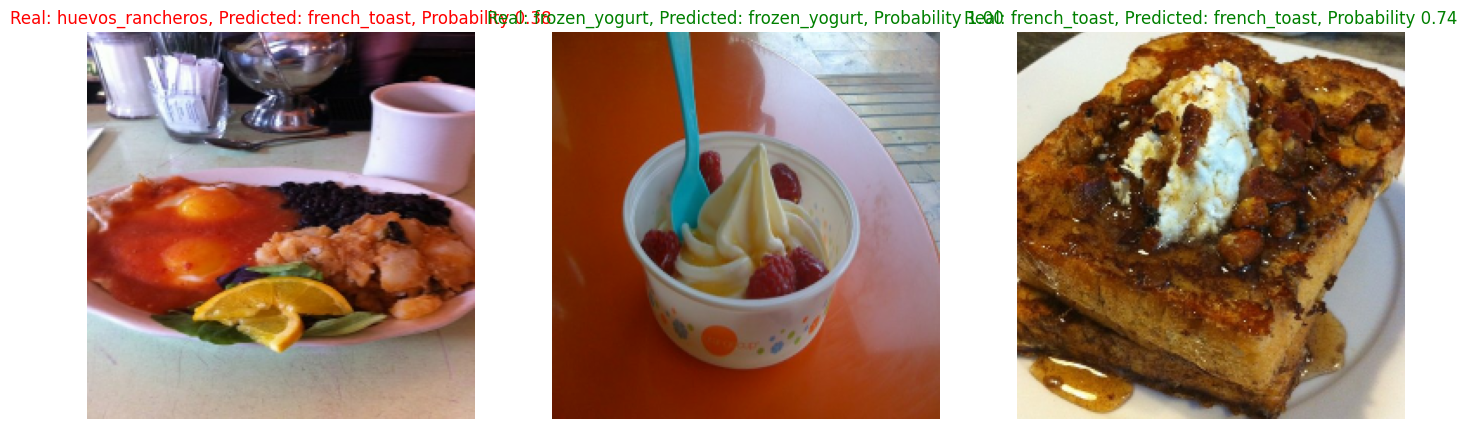

In [ ]:
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = random.choice(test_data.class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the img
  img = load_and_prep(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img,axis=0))
  pred_class = test_data.class_names[pred_prob.argmax()] # get the highest pred prob

  # Plot the imgs
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"Real: {class_name}, Predicted: {pred_class}, Probability {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong preditions

To find out where our model is most wrong:
1. Get all of the image file paths in the test dataset using list_files()
2. Creat a DataFrame of the image with truth label, max pred probs,
3. Find all the wrong predictions,
4. Sort the DataFrame based on wrong predictions (Descending order)
5. Visualize the img with the highest pred probs.

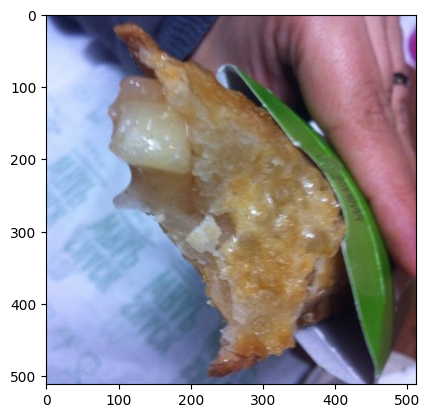

In [ ]:
for el in tf.data.Dataset.list_files(f"{test_dir}apple_pie/*.jpg", shuffle=False).as_numpy_iterator():
  plt.imshow(plt.imread(el.decode()))
  break

AxesImage(size=(224, 224))


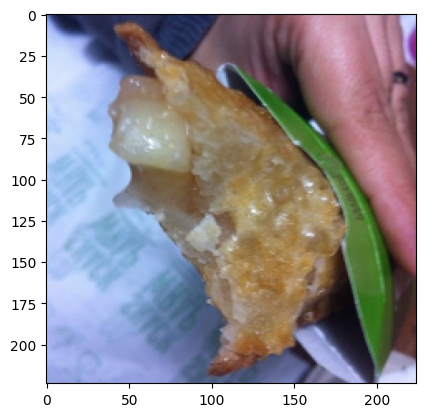

In [ ]:
for el in test_data:
  print(plt.imshow(el[0][0]/255.))
  break

In [ ]:
pred_probs_max = preds_probs.max(axis=1)
image_names = []
for index, el in enumerate(tf.data.Dataset.list_files(f"{test_dir}*/*.jpg", shuffle=False).as_numpy_iterator()):
  image_names.append({"path": el.decode(),
                      "truth": y_labels[index],
                      "pred": pred_classes[index],
                      "prob": pred_probs_max[index]})

In [ ]:
image_names

[{'path': '101_food_classes_10_percent/test/apple_pie/1011328.jpg',
  'truth': 0,
  'pred': 52,
  'prob': 0.8474181},
 {'path': '101_food_classes_10_percent/test/apple_pie/101251.jpg',
  'truth': 0,
  'pred': 0,
  'prob': 0.9640169},
 {'path': '101_food_classes_10_percent/test/apple_pie/1034399.jpg',
  'truth': 0,
  'pred': 0,
  'prob': 0.9592587},
 {'path': '101_food_classes_10_percent/test/apple_pie/103801.jpg',
  'truth': 0,
  'pred': 80,
  'prob': 0.6586067},
 {'path': '101_food_classes_10_percent/test/apple_pie/1038694.jpg',
  'truth': 0,
  'pred': 79,
  'prob': 0.36790094},
 {'path': '101_food_classes_10_percent/test/apple_pie/1047447.jpg',
  'truth': 0,
  'pred': 61,
  'prob': 0.45675474},
 {'path': '101_food_classes_10_percent/test/apple_pie/1068632.jpg',
  'truth': 0,
  'pred': 29,
  'prob': 0.6112438},
 {'path': '101_food_classes_10_percent/test/apple_pie/110043.jpg',
  'truth': 0,
  'pred': 0,
  'prob': 0.4731325},
 {'path': '101_food_classes_10_percent/test/apple_pie/110696

In [ ]:
import pandas as pd
df = pd.DataFrame(image_names)
# df.rename(columns={df.columns[0]: "Path"}, inplace=True)
# df.to_csv("m.csv")

In [ ]:
df_new = df[df['truth'] != df["pred"]]

In [ ]:
df_new = df_new.sort_values("prob", ascending=False)

In [ ]:
df_new

,path,truth,pred,prob
21810,101_food_classes_10_percent/test/scallops/1784...,87,29,0.999997
231,101_food_classes_10_percent/test/apple_pie/827...,0,100,0.999995
15359,101_food_classes_10_percent/test/lobster_roll_...,61,53,0.999988
23539,101_food_classes_10_percent/test/strawberry_sh...,94,83,0.999987
21400,101_food_classes_10_percent/test/samosa/314001...,85,92,0.999981
...,...,...,...,...
22303,101_food_classes_10_percent/test/shrimp_and_gr...,89,47,0.141997
15646,101_food_classes_10_percent/test/macaroni_and_...,62,19,0.139136
6092,101_food_classes_10_percent/test/clam_chowder/...,24,16,0.137614
168,101_food_classes_10_percent/test/apple_pie/343...,0,80,0.128813


In [ ]:
df_new.head(3).to_numpy()

array([['101_food_classes_10_percent/test/scallops/1784196.jpg', 87, 29,
        0.9999970197677612],
       ['101_food_classes_10_percent/test/apple_pie/827575.jpg', 0, 100,
        0.9999947547912598],
       ['101_food_classes_10_percent/test/lobster_roll_sandwich/2325607.jpg',
        61, 53, 0.9999877214431763]], dtype=object)

In [ ]:
def plot_the_top_wrong_photos(dataframe):
  plt.figure(figsize=(15, 10))
  for index, i in enumerate(df_new.head(4).to_numpy()):
    true_class_name = test_data.class_names[i[1]]
    pred_class_name = test_data.class_names[i[2]]
    prob = i[3]

    filepath = i[0]
    img = plt.imread(filepath)

    # Plot the imgs
    plt.subplot(2, 2, index+1)
    plt.imshow(img/255.)
    plt.title(f"Real: {true_class_name}, Predicted: {pred_class_name}, Probability {prob:.4f}", c="r")
    plt.axis(False)

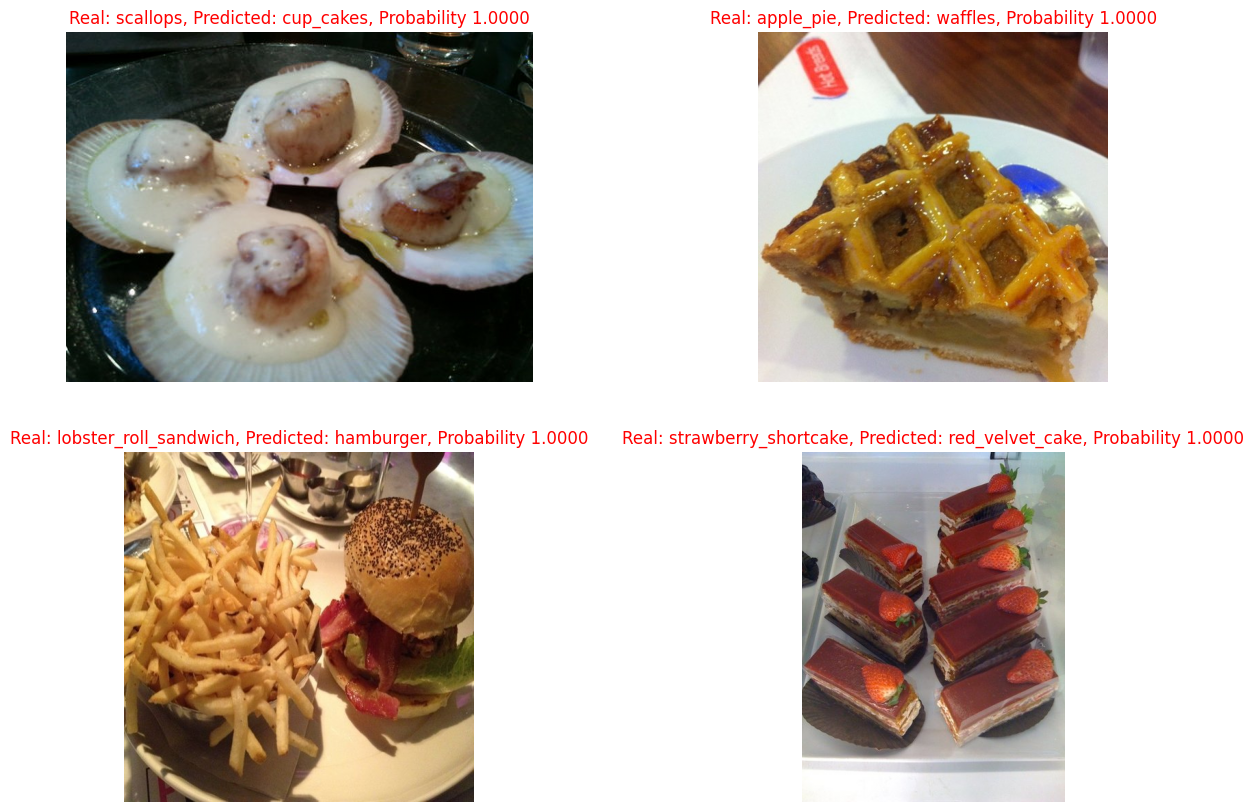

In [ ]:
plot_the_top_wrong_photos(df_new)

## Test out the big dog model on our custom images

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

In [ ]:
unzip_data("custom_food_images.zip")

In [ ]:
import os
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/IMG_20240418_200958_036.jpg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/msg828584954-286265.jpg']

In [ ]:
import tensorflow as tf
# Make pred and plot custom imgs
for img in custom_food_images:
  img = load_and_prep(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = test_data.class_names[pred_prob.argmax()]

  # Plot
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"Pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False);

Output hidden; open in https://colab.research.google.com to view.

## Exercises

### Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?

In [24]:
import tensorflow as tf

In [25]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2024-04-20 17:46:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.207, 173.194.195.207, 173.194.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   235MB/s    in 9.8s    

2024-04-20 17:46:56 (159 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [26]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-04-20 17:46:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-20 17:46:57 (90.7 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [27]:
from helper_functions import *

In [28]:
unzip_data("101_food_classes_10_percent.zip")

In [29]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [30]:
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [31]:
from tensorflow import keras

data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomZoom(0.2),
    keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomHeight(0.2),
    keras.layers.experimental.preprocessing.RandomWidth(0.2)
])

In [ ]:
# Model_1 - 10 epochs
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input(IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(101, activation="softmax")(x)

model_1 = keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model_1.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.categorical_crossentropy,
    metrics=["accuracy"]
)

In [ ]:
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_acc',
    patience=2
)

In [ ]:
history_1 = model_1.fit(
    train_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data))
)

Epoch 1/10
237/237 [==============================] - 94s 391ms/step - loss: 1.5842 - accuracy: 0.6181 - val_loss: 1.6332 - val_accuracy: 0.5734
Epoch 2/10
237/237 [==============================] - 86s 360ms/step - loss: 1.4295 - accuracy: 0.6532 - val_loss: 1.5844 - val_accuracy: 0.5821
Epoch 3/10
237/237 [==============================] - 88s 370ms/step - loss: 1.3319 - accuracy: 0.6725 - val_loss: 1.5542 - val_accuracy: 0.5853
Epoch 4/10
237/237 [==============================] - 92s 383ms/step - loss: 1.2201 - accuracy: 0.6977 - val_loss: 1.5253 - val_accuracy: 0.5959
Epoch 5/10
237/237 [==============================] - 65s 271ms/step - loss: 1.1320 - accuracy: 0.7187 - val_loss: 1.5171 - val_accuracy: 0.5956
Epoch 6/10
237/237 [==============================] - 60s 252ms/step - loss: 1.0679 - accuracy: 0.7373 - val_loss: 1.5216 - val_accuracy: 0.5930
Epoch 7/10
237/237 [==============================] - 57s 240ms/step - loss: 1.0088 - accuracy: 0.7463 - val_loss: 1.5114 - val_ac

In [ ]:
results_1 = model_1.evaluate(test_data)

790/790 [==============================] - 54s 68ms/step - loss: 1.5054 - accuracy: 0.5979


In [35]:
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input(IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(101, activation="softmax")(x)

model_2 = keras.Model(inputs, outputs)

In [37]:
model_2.compile(
  optimizer=keras.optimizers.Adam(),
  loss=keras.losses.categorical_crossentropy,
  metrics=["accuracy"]
)

In [39]:
history_2 = model_2.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data))
)

Epoch 1/5
237/237 [==============================] - 59s 207ms/step - loss: 3.3593 - accuracy: 0.2754 - val_loss: 2.2607 - val_accuracy: 0.4955
Epoch 2/5
237/237 [==============================] - 47s 197ms/step - loss: 2.1941 - accuracy: 0.4935 - val_loss: 1.8299 - val_accuracy: 0.5553
Epoch 3/5
237/237 [==============================] - 45s 188ms/step - loss: 1.8158 - accuracy: 0.5662 - val_loss: 1.6746 - val_accuracy: 0.5704
Epoch 4/5
237/237 [==============================] - 49s 203ms/step - loss: 1.5966 - accuracy: 0.6135 - val_loss: 1.6048 - val_accuracy: 0.5763
Epoch 5/5
237/237 [==============================] - 43s 179ms/step - loss: 1.4594 - accuracy: 0.6448 - val_loss: 1.5540 - val_accuracy: 0.5890


In [40]:
# Fine-tuning
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [41]:
model_2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.categorical_crossentropy,
    metrics=["accuracy"]
)

In [42]:
history_2_fine_tuned = model_2.fit(
    train_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    initial_epoch=history_2.epoch[-1]
)

Epoch 5/10
237/237 [==============================] - 57s 204ms/step - loss: 1.2041 - accuracy: 0.6846 - val_loss: 1.4895 - val_accuracy: 0.5977
Epoch 6/10
237/237 [==============================] - 41s 173ms/step - loss: 1.0831 - accuracy: 0.7085 - val_loss: 1.4714 - val_accuracy: 0.6006
Epoch 7/10
237/237 [==============================] - 41s 170ms/step - loss: 1.0017 - accuracy: 0.7324 - val_loss: 1.4702 - val_accuracy: 0.6059
Epoch 8/10
237/237 [==============================] - 42s 174ms/step - loss: 0.9445 - accuracy: 0.7455 - val_loss: 1.4534 - val_accuracy: 0.6096
Epoch 9/10
237/237 [==============================] - 52s 218ms/step - loss: 0.8929 - accuracy: 0.7604 - val_loss: 1.4630 - val_accuracy: 0.6070
Epoch 10/10
237/237 [==============================] - 52s 218ms/step - loss: 0.8267 - accuracy: 0.7814 - val_loss: 1.4652 - val_accuracy: 0.6104


In [43]:
results_2 = model_2.evaluate(test_data)

790/790 [==============================] - 60s 75ms/step - loss: 1.4882 - accuracy: 0.6056


results_1 =

790/790 [==============================] - 54s 68ms/step - loss: 1.5054 - accuracy: 0.5979

In [44]:
results_2

[1.488205909729004, 0.6055841445922852]

### Experiment 2 mixed-precisions

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, mixed_precision

In [3]:
policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

In [4]:
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float32
Variable dtype: float32


In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-04-20 18:49:24--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-20 18:49:24 (51.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [6]:
from helper_functions import *

In [7]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2024-04-20 18:49:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.207, 142.251.163.207, 142.251.16.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   110MB/s    in 14s     

2024-04-20 18:49:41 (108 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [8]:
unzip_data("101_food_classes_10_percent.zip")

In [9]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [10]:
IMG_SIZE = (224, 224)

train_data = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE
)

test_data = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [11]:
from tensorflow import keras

data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomZoom(0.2, dtype="float32"),
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", dtype="float32"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2, dtype="float32"),
    keras.layers.experimental.preprocessing.RandomHeight(0.2, dtype="float32"),
    keras.layers.experimental.preprocessing.RandomWidth(0.2, dtype="float32")
])

In [12]:
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(IMG_SIZE+(3,))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(101,)(x)
outputs = layers.Activation("softmax", dtype="float32")(x)

model = keras.Model(inputs, outputs)
print('Outputs dtype: %s' % outputs.dtype.name)

Outputs dtype: float32


In [13]:
model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.categorical_crossentropy,
                metrics=["accuracy"])

In [14]:
initial_weights = model.get_weights()

In [16]:
history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data))
)

Epoch 1/5


KeyboardInterrupt: 

8:30 min (float32) -> 17:00 min (mixed_bfloat16) maybe on gpu or tpu wil be better